<a href="https://colab.research.google.com/github/melchiorv/skills-introductions-to-github/blob/main/M4LP_Assignment_2_(2026)_Student_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 2

This is the complete Assignment 2. You are asked to train and test linear and logistic regression models and access lexical resources.

# <font color="red">Contributions</font>

~~Delete this text and write instead of it your:~~
* ~~group number (same as the file name, for sanity chack)~~
* ~~a list of group members names (NOT student IDs)~~
* ~~who contributed to which exercises (you don't need to be very detailed)~~

To start the assignment, import prerequisite packages:

In [1]:
import nltk,sklearn
import csv
import torch
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import collections, itertools
import more_itertools

GloVe word embeddings will be loaded through gensim package:

This is all you need. **Do not import anything else at other points** except where suggested.




# 2.1 Load GloVe word embedding model

GloVe contains _static_ word embeddings. This means that the vector is assigned to word types and does not vary in different contexts or for different word senses. Pretrained GloVe word embedding models exist in different sizes. For the purpose of the exercise, we will use the smallest GloVe vectors with 50 dimensions. First, let's download the vectors and load the embedding model as `glove`. This may take a few minutes.

In [2]:
!pip install gensim
import gensim.downloader as api

In [3]:
glove = api.load("glove-wiki-gigaword-50")

**Another download workaround**. Sometimes StanfordNLP server is down and the embeddings don't load. In this case, you can obtain them from other sources. For example, download the embeddings from Kaggle (https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation?select=glove.6B.50d.txt), unzip the file and upoad it to the Colab working directory (left panel on Colab). Then uncomment and run:

In [4]:
#from gensim.models import KeyedVectors
#glove = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False, no_header=True)

The exercises below require understanding of gensim vector spaces. You can learn some basics from a tutorial on [word2vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html), which is an alternative to GloVe. For example, you will see in the tutorial that gensim word2vec has `wv.index_to_key` and `wv.key_to_index` attributes. By using a similar attribute of `glove`, we can count how many words the GloVe embeddings contain:

In [5]:
len(glove.key_to_index)

400000

We can also check if particular orthographic words have vectors in `glove`.

**Exercise**. Check if strings 'asdfdfasd', "catc", "cact", and "cat" have a glove vector, and print the resuts as truth values.

In [6]:
# your code here
#vec_asdfdfasd = glove['asdfdfasd']
vec_catc = glove['catc']
#vec_cact = glove['cact']
vec_cat = glove['cat']





**Exercise**. What is the vector of _cat_? Print it.



In [7]:
#your code here
print(vec_cat)


[ 0.45281  -0.50108  -0.53714  -0.015697  0.22191   0.54602  -0.67301
 -0.6891    0.63493  -0.19726   0.33685   0.7735    0.90094   0.38488
  0.38367   0.2657   -0.08057   0.61089  -1.2894   -0.22313  -0.61578
  0.21697   0.35614   0.44499   0.60885  -1.1633   -1.1579    0.36118
  0.10466  -0.78325   1.4352    0.18629  -0.26112   0.83275  -0.23123
  0.32481   0.14485  -0.44552   0.33497  -0.95946  -0.097479  0.48138
 -0.43352   0.69455   0.91043  -0.28173   0.41637  -1.2609    0.71278
  0.23782 ]


**Exercise**. Which dimensions of vectors for "cat" and "dog" are similar, i.e. different by no more than 0.25? Print their indices. How many such dimensions are there? What is the proportion of similar dimensions out of all dimensions?



In [8]:
#your code here
vec_dog = glove['dog']
similar_dimensions  =  []
vec_dif = abs(vec_dog - vec_cat)
for i in range(50):
  if(vec_dif[i] <= 0.25):
    similar_dimensions.append(i)



dif = len(similar_dimensions)
print("Indices of similar dimensions:",similar_dimensions)
print("Number of similar dimensions:", dif)
print(f"Proportion of similar dimensions:{dif/50}" )


Indices of similar dimensions: [1, 2, 5, 11, 13, 14, 18, 20, 21, 24, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 48, 49]
Number of similar dimensions: 29
Proportion of similar dimensions:0.58


**Exercise**. Compute the cosine of vectors for _cat_ and _dog_ using a gensim built-in function.

In [9]:
#your code here
print(glove.similarity("dog","cat"))

0.9218005


# 2.2 Linear regression: Concreteness prediction

Obtain concreteness ratings from the paper

Brysbaert, M., Warriner, A., & Kuperman, V. (2014). Concreteness ratings for 40 thousand generally known English word lemmas. BEHAVIOR RESEARCH METHODS, 46 (3), 904–911. https://doi.org/10.3758/s13428-013-0403-5

In [10]:
!wget https://raw.githubusercontent.com/ArtsEngine/concreteness/master/Concreteness_ratings_Brysbaert_et_al_BRM.txt

--2026-02-06 16:19:06--  https://raw.githubusercontent.com/ArtsEngine/concreteness/master/Concreteness_ratings_Brysbaert_et_al_BRM.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1646191 (1.6M) [text/plain]
Saving to: ‘Concreteness_ratings_Brysbaert_et_al_BRM.txt.3’

Concreteness_rating 100%[===================>]   1.57M  --.-KB/s    in 0.1s    

2026-02-06 16:19:06 (12.1 MB/s) - ‘Concreteness_ratings_Brysbaert_et_al_BRM.txt.3’ saved [1646191/1646191]



This is a tab-separated file with a header. Structured data like this can be conveniently read via DictReader class from csv.

Using DictReader, we create lists ```concreteness_words``` and ```concreteness_scores``` of words in the concreteness ratings file that have a GloVe vector

In [11]:
concreteness_words=[]
concreteness_scores=[]
with open("Concreteness_ratings_Brysbaert_et_al_BRM.txt",'r') as concfile:
  read_tsv = csv.DictReader(concfile, delimiter="\t")
  for row in read_tsv:
    word=row["Word"]
    if word in glove:
      concreteness_words.append(word)
      concreteness_scores.append(float(row["Conc.M"]))

How many words ended up in your concreteness dataset?

In [12]:
print(len(concreteness_words))

31618


We can now create train and test partitions of concreteness data (conc_words_train, conc_words_test, conc_scores_train, conc_scores_test) with 10% test and 90% training split. Do not use random state.

In [13]:
conc_words_train, conc_words_test, conc_scores_train, conc_scores_test = train_test_split(concreteness_words,concreteness_scores,test_size=0.1)

Convert data to torch tensor format to use in a regression model (ignore UserWarning):

In [14]:
conc_vectors_train = torch.from_numpy(np.array([glove[word] for word in conc_words_train]))
conc_vectors_test = torch.from_numpy(np.array([glove[word] for word in conc_words_test]))
conc_scores_train = torch.tensor(conc_scores_train, dtype=torch.float32)
conc_scores_test = torch.tensor(conc_scores_test, dtype=torch.float32)

**Exercise** Explain in a couple of sentences what the second and third lines of code in the above cell does.

YOUR EXPLANATION HERE



Now we can define linear regression model in pyTorch:

In [15]:
class Regression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(Regression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = self.linear(x)
         return outputs

**Exercise**. Study pyTorch documentation at

https://docs.pytorch.org/tutorials/index.html

to understand the definition of the regression class. Explain each line of the class definition above. For example, line 3 can be explained as follows:

Line 3 `super(Regression, self).__init__()` initializes a new Regression model as an instance of the parent class `torch.nn.Module`

Now explain all other lines of the class code.

ADD YOUR ANSWER HERE

Line 1 is the class defintion that borows form torch.nn.Module class
Line 2 is the constructor methode that takes the input dimention en output dimention for liniar regresion
Line 4 makes a funtion that takes it from torch.nn.linear and uses input_dim oupout_dim
Line 5 is function that takes tensors x en returns 1d values after linear regresion
Line 6 safe the output valus of liniar regression in the outputs variable
Line 7 return outputs

A specific linear regression model can have the input dimensionality of our word embeddings and 1-dimensional input (the concretenss score)

In [16]:
glovedim=50

In [17]:
model = Regression(glovedim,1)

To train the model, we need a loss function and an optimiser, including the learning rate parameter. We choose Mean Square Error loss (suitable for learning linear regression) and Stochastic Gradient Descent method with the learning rate of 0.1.

In [18]:
criterion = torch.nn.MSELoss()

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

**How PyTorch learns from data**

Training a neural network means adjusting its parameters (weights and biases) so that its predictions get closer to the true values. PyTorch does this in four steps, repeated each epoch:

- **Forward pass**: Input data flows through the model to produce predictions. Behind the scenes, PyTorch builds a computation graph — a record of every operation performed on the data.
- **Loss calculation**: We measure how wrong the predictions are using a loss function (here, mean squared error).
- **Backward pass** (`loss.backward()`): PyTorch walks backward through the computation graph, calculating gradients — these tell us how much each parameter contributed to the error, and in which direction it should change.
- **Parameter update** (`optimizer.step()`): The optimizer adjusts each parameter by a small amount in the direction that reduces the loss.

We call `zero_grad()` at the start because PyTorch accumulates gradients by default — without clearing them, gradients from previous epochs would mix with the current ones.

A **computation graph** represents how outputs are computed from inputs, step by step. For training purposes, the inputs are model parameters (`linear.weight` and `linear.bias`) and the output is the loss value. A computation graph can be visualized in a diagram like:

```
  ┌───────────────────────┐
  │   linear.weight       │
  │   linear.bias         │
  └───────────────────────┘
              │
              ▼
           (Addmm)
              │
              ▼
          (MseLoss)
              │
              ▼
            loss
            


The computation graph (simplified for expository purposes) shows what PyTorch tracks: learnable parameters of the linear layer (weights and bias) udergo matrix multiplication with data and bias addition, then feed into the loss function.

Why does the computation graph matter? To train the model, we need to know: "If I nudge a weight slightly, how much does the loss change?" When we call `loss.backward()`, PyTorch traverses this graph in reverse, from loss back to the parameters, computing gradients along the way. These gradients tell the optimizer how to adjust each parameter to reduce the loss.

We can now train our linear regression model using gradient descent.

**Exercise**. Every 5 training steps, evaluate the model, printing out loss and accuracy for the training and test sets. Calculate the accuracy as the percentage of examples where the predicted score of the model differs from the correct score by less than 1. The training may take a minute or so.

In [34]:
losses = []
losses_test = []
Iterations = []
epochs=20
tolerance = 1
#after defining parameters, we train the model several times on the same data; each iteration is an epoch:
for epoch in trange(epochs, desc='Training Epochs'):
    x = conc_vectors_train
    scores = conc_scores_train
    #clear gradients from previous epoch (PyTorch accumulates them by default)
    optimizer.zero_grad()
    #here we pass the word vectors from the training set, obtaining regression model's predicted outputs:
    outputs = model(x)
    #compute the loss: how far are predictions from true scores?
    loss = criterion(torch.squeeze(outputs), scores)
    #compute gradients: how should each parameter change to reduce the loss?
    loss.backward()
    #update model parameters using the computed gradients
    optimizer.step()

    #Now, every 5 epochs we can evaluate how the model performs on the data
    if (epoch + 1) % 5 == 0:
        #we don't compute gradients as the model is only evaluated and not updated
        with torch.no_grad():
            model.eval()
            #complete the code here

            test = model( conc_vectors_test)
            lossTe = criterion(torch.squeeze(test), conc_scores_test)

            difreTr = torch.abs(torch.squeeze(outputs) - scores)
            difreTe = torch.abs(torch.squeeze(test) - conc_scores_test)

            accurateTr = []
            for i in difreTr:
              if i < 1:
                accurateTr.append(i)

            accuracyTr = len(accurateTr)/len(scores)

            accurateTe = []
            for i in difreTe:
              if i < 1:
                accurateTe.append(i)

            accuracyTe = len(accurateTe)/len(conc_scores_test)

            print(f"Loss train:{loss.item()}")
            print(f"Accuracy train:{accuracyTr}")
            print(f"Loss test:{lossTe.item()}")
            print(f"Accuracy test:{accuracyTe}")







Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Loss train:0.4461430609226227
Accuracy train:0.8673390497610346
Loss test:0.4604054093360901
Accuracy test:0.8580012650221379
Loss train:0.4457422196865082
Accuracy train:0.8677958954174867
Loss test:0.45995938777923584
Accuracy test:0.8586337760910816
Loss train:0.4454334080219269
Accuracy train:0.8680418892324993
Loss test:0.45960763096809387
Accuracy test:0.8586337760910816
Loss train:0.445194810628891
Accuracy train:0.8682878830475119
Loss test:0.45932891964912415
Accuracy test:0.8589500316255535


The real computation graph used by pyTorch here is a little more complex than the schematic illustration we gave above; if you want to visualize it (using the familiar `graphviz` as the underlying engine), uncomment and run:

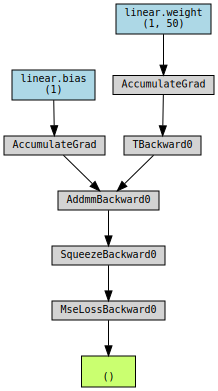

In [28]:
!pip install torchviz
from torchviz import make_dot
make_dot(loss, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)

<details>
<summary><b>Click to see detailed explanation</b></summary>

**Understanding the computation graph**

The `torchviz` diagram shows the following nodes:

| Node | What it is |
|------|------------|
| `linear.weight (1, 50)` | The learnable weight matrix of our linear layer: 50 input dimensions mapped to 1 output |
| `linear.bias (1)` | The learnable bias term of our linear layer: a single value added to the output |
| `AccumulateGrad` | A marker indicating "this is a leaf node where gradients will be accumulated" — appears next to each learnable parameter |
| `TBackward0` | The backward operation for transpose (`T`): PyTorch transposes the weight matrix during the linear calculation |
| `AddmmBackward0` | The backward operation for `addmm` (add + matrix multiply). This computes `bias + input @ weight.T`, which is what `nn.Linear` does internally |
| `SqueezeBackward0` | The backward operation for `squeeze()`: shape adjustment from `(n, 1)` to `(n,)` |
| `MseLossBackward0` | The backward operation for mean squared error loss |

The "Backward" suffix indicates these are the *reverse* operations that PyTorch will use during backpropagation. The graph is built during the forward pass, but it stores the operations needed to compute gradients in reverse.

Reading from bottom to top, the forward pass was:
1. Take `linear.weight` and transpose it (`TBackward0`)
2. Multiply input by transposed weights and add bias (`AddmmBackward0`)
3. Squeeze the output shape (`SqueezeBackward0`)
4. Compute MSE loss against target scores (`MseLossBackward0`)

When we call `loss.backward()`, PyTorch traverses from top to bottom, computing gradients at each step until it reaches the `AccumulateGrad` nodes, where gradients are stored in `linear.weight.grad` and `linear.bias.grad`.
</details>

**Exercise**. What are the predicted concreteness score of the nouns _logarithm_ and _mouse_? Print them.



In [22]:
def predicted_concreteness(wd):
  #complete the code here

print("On the scale from 1 to 5, our trained regression model predicts the concreteness scoere of 'logarithm' to be",predicted_concreteness("logarithm"))

IndentationError: expected an indented block after function definition on line 1 (ipython-input-3437503513.py, line 4)

In [ ]:
print("On the scale from 1 to 5, our trained regression model predicts the concreteness scoere of 'mouse' to be",predicted_concreteness("mouse"))

# 2.3. Create a dataset of WordNet supersenses for words that have GloVe vectors.

First, download the WordNet database:

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

You can read documentation on object types in WordNet, for example by invoking the types:

In [ ]:
nltk.corpus.reader.wordnet.Lemma

In [ ]:
nltk.corpus.reader.wordnet.Synset

**Exercise**. Now, retrieve the first lemma corresponding to the adjective _dry_ as `d`:

In [ ]:
d=

**Exercise**. What lemmas belong to the same SynSet? Retrieve the list.

In [ ]:
#your code here

**Exercise**. Define function `ant_freq` that returns the frequency of (the first) antonym of a lemma.


In [ ]:
def ant_freq(x):
  #your code here

Apply `ant_freq` to `d`. This will output the frequency of _wet_.

In [ ]:
ant_freq(d)

**Exercise**. Now, create a dataset that includes for each word in WordNet that has a GloVe vector the lexicographic file (supersense) of its first synset.

In [ ]:
#your code here
wn_words =
#wn_words = [w for w in wn.all_lemma_names() if w in glove]
wn_supersenses =

Split the dataset into train and test partitions:

In [ ]:
wn_words_train, wn_words_test, wn_supersenses_train, wn_supersenses_test = train_test_split(wn_words,wn_supersenses,test_size=0.1)

# 2.4. Logistic regression: word class prediction.

Now we can address a classification task. Define a (multinomial) regression model using softmax, choose a loss function and an optimizer for it.

**Exercise**. We will need to set the number of classes for classification. Estimate `num_classes`prior to initializing the model. Use `wn_supersenses`.

In [ ]:
num_classes =

Initialize your model. Use the same Regression class for logistic regression as for linear regression - the difference will come from the objective (loss) function. The output now is not a single number but scores for each of the classes in the classification task.

In [ ]:
logreg_model = Regression(glovedim,num_classes)

**Exercise**. Choose the loss function. This is a crucial choice: some of the loss functions in PyTorch (see https://pytorch.org/docs/stable/nn.html) already include a softmax or a sigmoid in their implementaion, which gives computational advantages. Be sure to read the documentation on your loss function to confirm you made a good choice.

In [ ]:
#your code here
loss4logreg =

**Exercise**.  Initialize the optimiser:

In [ ]:
#your code here
logregoptimiser =

WordNet is quite big. For efficiency, use the following function for splitting your data into batches when processing:

In [ ]:
batch_size = 200
def get_batches(src_iter, tgt_iter, batch_size=batch_size):
    for batch in more_itertools.chunked(zip(src_iter, tgt_iter), batch_size):
        x, y = zip(*batch)
        x = torch.stack(x)
        y = torch.stack(y)
        yield x, y

**Exercise**. Train and test your logistic regression model, printing the train and test loss and accuracy:

In [ ]:
#your code here

**Exercise**. Define a mapping from indices to lexicographic file names:

In [ ]:
#your code
itolexname =

What is the name of lexicographic file 2?

In [ ]:
itolexname[2]

**Exercise**. Which supersense (lexicographic file) does your classifier assign to the noun _house_?

In [ ]:
def predicted_lexname(wd):

Which supersense (lexicographic file) does your classifier assign to the noun _house_?

In [ ]:
predicted_lexname("house")

Which supersense (lexicographic file) does your classifier assign to the noun _hog_?

In [ ]:
predicted_lexname("hog")

# 2.5. Hypernymy classification

Now, download a lexical entailment (hypernymy) dataset called WBLESS. The dataset was developed by Weeds et al. with the goal of testing models on distinguishing hypernyms from other related word pairs.

Weeds et al. (2014) Julie Weeds, Daoud Clarke, Jeremy Reffin, David Weir, and Bill Keller. 2014. Learning to distinguish hypernyms and co-hyponyms. In Proceedings of the 2014 International Conference on Computational Linguistics, pages 2249–2259, Dublin, Ireland.

WBLESS (together with other relevant datasets) can be conveniently downloaded from the Facebook Research github page by Stephen Roller who worked on hypernymy learning:

Stephen Roller, Douwe Kiela, and Maximilian Nickel. 2018. Hearst Patterns Revisited: Automatic Hypernym Detection from Large Text Corpora. ACL.

Download the tab-separated dataset:

In [ ]:
!wget https://github.com/facebookresearch/hypernymysuite/raw/main/data/wbless.tsv

Check how the data looks:

In [ ]:
!head wbless.tsv

We used ```csv``` above to process a tab separated file. It can also be done using ```pandas```:

In [ ]:
wbless_df = pd.read_csv('wbless.tsv', sep='\t')
wbless_df.head()

**Exercise**. Now create training and test data for relation classification:

In [ ]:
#your code here
wbless_words =
hypernymy =

Split into training and test data:

In [ ]:
wbless_words_train, wbless_words_test, hypernymy_train, hypernymy_test = train_test_split(wbless_words,hypernymy,test_size=0.1)

**Exercise**. Create, train and test a logistic regression model that predicts whether two words stand in the hypernymy relation given their GloVe vectors.

Make sure your model predicts a single score used for the binary decision (hypernymy vs. non-hypernymy) rather than scores for multiple classes, and choose the loss function in pyTorch accordingly.

Print the train and test loss and accuracy. Use the concatenation of the two words' vectors as input to the logistic regression classifier.

In [ ]:
#your code here

**Exercise**. What label does your model predict for the pair _dog,animal_? Your code below should produce a Boolean value, `True` for the positive class (hypernymy) and `False` for the negative class (not hypernymy).

In [ ]:
def predicted_hypernymy(w1, w2):
#your code here


print("Predicted hypernymy, i.e. whether 'animal' is a hypernym of 'dog':",predicted_hypernymy("dog","animal"))

What label does your model predict for the pair _dog,cat_?

In [ ]:
print("Predicted hypernymy, i.e. whether 'cat' is a hypernym of 'dog':",predicted_hypernymy("dog","cat"))

What label does your model predict for the pair _animal,dog_?

In [ ]:
print("Predicted hypernymy, i.e. whether 'dog' is a hypernym of 'animal':",predicted_hypernymy("animal","dog"))

#2.6 Using FrameNet



You can explore FrameNet online:
https://framenet.icsi.berkeley.edu/frameIndex

Or read detailed documentation here:
https://framenet2.icsi.berkeley.edu/docs/r1.7/book.pdf

Now, load FrameNet via the NLTK package:

In [ ]:
nltk.download('framenet_v17')
from nltk.corpus import framenet as fn

`fn.lus` allows to retrieve lexical units (LUs) recorded in FrameNet. A lexical unit approximately corresponds to a lemma in WordNet, i.e. a word taken in a specific sense. Without additional parameters, it returns a complete list:



In [ ]:
fn.lus()

You can also retrieve lexical units by regular expression search. For example, the following returns the list of LUs that contain string _pres_ at the beginning of the LU name:

In [ ]:
fn.lus('^pres')

Individual lexical units can be retrieved by ID, for example:

In [ ]:
fn.lu(10117)

Terms that show up in square brackets are attributes, in this case of the lexical unit. They include usage examples:

In [ ]:
fn.lu(10117).exemplars

... and the frame that the lexical unit evokes, which in turn has its own attributes:

In [ ]:
fn.lu(10117).frame

**Exercise**. Find all LUs on FrameNet that share the frame with the noun *car*. Print these words along with their definitions.

In [ ]:
#your code here

**Exercise**. Define a function that takes a FrameNet frame as input and prints out the definitions of all core frame elements associated with the frame. For example, for the frame associated with the noun _car_ your function will print the definition of the only core frame element _Vehicle_:


> Vehicle is the transportation device that the human beings use to travel.This FE is incorporated into each LU in this frame.




In [ ]:
def printcoreFE(frame):
  """
  Args:
    frame: a frame object from FrameNet
  """
  #your code here

**Exercise**. Test your function on the frame evoked by the verb _sing_:



In [ ]:
#your code here
sing=

printcoreFE(frame=sing)